# How to use the data in this dandiset

First let's colllect all the nwb assets in this dandiset.

In [1]:
from dandi.dandiapi import DandiAPIClient

dandi_api_key = "your_dandi_api_key"  # TODO, change when the dandiset becomes public  
print(f"Using token: {dandi_api_key} as the data is embargoed")
client = DandiAPIClient.for_dandi_instance("dandi", token=dandi_api_key)

dandiset_id = "000727"
dandiset = client.get_dandiset(dandiset_id)
asset_list = [asset for asset in dandiset.get_assets() if "nwb" in asset.path]
# The paths are:
[asset.path for asset in asset_list]

Using token: 332607d7e1f20e81521309c96f726cf4a30f33b5 as the data is embargoed


['sub-fly-098/sub-fly-098_ses-20200627130208_behavior+image+ophys.nwb',
 'sub-fly-097/sub-fly-097_ses-20200627113329_behavior+image+ophys.nwb',
 'sub-fly-089/sub-fly-089_ses-20200618081653_behavior+image+ophys.nwb',
 'sub-fly-094/sub-fly-094_ses-20200620122048_behavior+image+ophys.nwb',
 'sub-fly-087/sub-fly-087_ses-20200228161226_behavior+image+ophys.nwb',
 'sub-fly-100/sub-fly-100_ses-20200702083849_behavior+image+ophys.nwb',
 'sub-fly-099/sub-fly-099_ses-20200627142647_behavior+image+ophys.nwb',
 'sub-fly-101/sub-fly-101_ses-20200702100612_behavior+image+ophys.nwb',
 'sub-fly-105/sub-fly-105_ses-20200704142706_behavior+image+ophys.nwb']

In [2]:
# Let's pick the first one
asset = asset_list[0]

# We could use get content url
# s3_url = asset.get_content_url(follow_redirects=True, strip_query=True)

# But for embargoed data we need to use the download url to get this with identification

import requests

url = f"https://api.dandiarchive.org/api/dandisets/{asset.dandiset_id}/versions/{asset.version_id}/assets/{asset.identifier}/download"
headers = {
    "Authorization": f'token {dandi_api_key}'
}
response = requests.get(url, headers=headers, stream=True)
authorized_url = response.url
s3_url = authorized_url

Once we have the url we can stream the data to read the nwbfile with fsspec (this takes around 2 minutes in a local computer)

In [3]:
import fsspec
from h5py import File
from pynwb import NWBHDF5IO

fs = fsspec.filesystem("http")
ffspec_file = fs.open(s3_url, "rb")

file = File(name=ffspec_file, mode="r")
io = NWBHDF5IO(file=file, load_namespaces=True)
nwbfile = io.read()

In [4]:
two_photon_series_anatomical_red = nwbfile.acquisition["TwoPhotonSeriesAnatomicalRed"]
two_photon_series_anatomical_red.data.shape


(100, 1024, 512, 241)

In [5]:
# Let's visualize the average value of one of the planes
plane_index = 100

mean_plane = two_photon_series_anatomical_red.data[..., plane_index].mean(axis=0)
mean_plane.shape

(1024, 512)

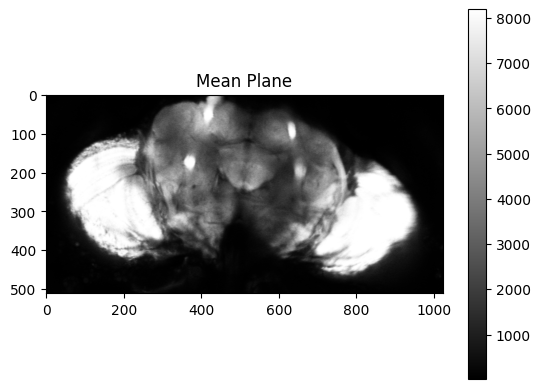

In [6]:
import matplotlib.pyplot as plt

plt.imshow(mean_plane.T, cmap='gray')
plt.colorbar()
plt.title('Mean Plane')
plt.show()
